<a href="https://colab.research.google.com/github/kozz84/Image-analysis/blob/main/Image_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
import glob, os
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage.segmentation import clear_border
from skimage import morphology
from skimage.measure import label, regionprops, regionprops_table
from skimage.color import label2rgb
import pandas as pd

DATE: 09/03/2021
PIXEL SIZE: 2.480469 nm
IMAGE SIZE: 2560x1920


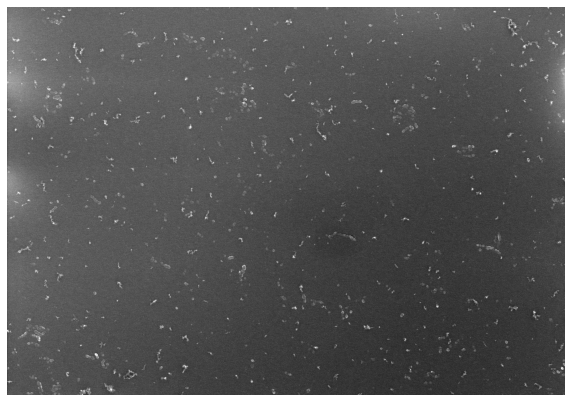

In [66]:
img = io.imread('/content/drive/MyDrive/CIOP/images/210902_#6_100_10_1um_i004.tif', as_gray=True)
img = np.array(img).astype(np.float32)

with open(f'/content/drive/MyDrive/CIOP/images/210902_#6_100_10_1um_i004.txt','r') as txt_file:
    txt = txt_file.read()
    del txt_file
    txt=txt.split('\n')
    txt=txt[1:-1]
    sem_dict = {}
    for row in txt:
        row = row.split('=')
        sem_dict.update({row[0]:  row[1]}) 
    print('DATE:',sem_dict['Date'] )    
    print('PIXEL SIZE:', sem_dict['PixelSize'],'nm')
    print('IMAGE SIZE:', sem_dict['DataSize'])
    pixelsize = float(sem_dict['PixelSize'])
    width, height = sem_dict['DataSize'].split('x')
    width, height = int(width), int(height)
    if height == 1920:
        img = img[0:1780,0:2560]
        height = 1780
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img,vmax=255, cmap='gray')

In [67]:
def uniform(num_rec_x,num_rec_y):
    img2 = np.copy(img)
    rec_size_x = int(int(height)/num_rec_x)
    rec_size_y = int(int(width)/num_rec_y)
    print("Median Rectangle Box size:",rec_size_x,"x", rec_size_y)
    print("Median intensity:",np.median(img))
    median_img=[]
    median_img2=[]
   
    for i in range(num_rec_x):
      for j in range(num_rec_y):
          x_min=i*rec_size_x
          y_min=j*rec_size_y
          x_max=x_min+rec_size_x
          y_max=y_min+rec_size_y
          median_img.append(np.median(img2[x_min:x_max,y_min:y_max]))
          img2[x_min:x_max,y_min:y_max]=img[x_min:x_max,y_min:y_max] - np.median(img[x_min:x_max,y_min:y_max])
    for i in range(num_rec_x):
      for j in range(num_rec_y):
          x_min=i*rec_size_x
          y_min=j*rec_size_y
          x_max=x_min+rec_size_x
          y_max=y_min+rec_size_y
          if np.median(img[x_min:x_max,y_min:y_max]) > np.median(median_img)*1.15 or np.median(img[x_min:x_max,y_min:y_max]) < np.median(median_img)*0.85 :
              #print(np.median(img[x_min:x_max,y_min:y_max]))
         
              img2[x_min:x_max,y_min:y_max] = 255
    img2[img2<0] = 0
    return img2, median_img, median_img2
img2, median_img,media_img2 = uniform(20,20)

Median Rectangle Box size: 89 x 128
Median intensity: 113.0


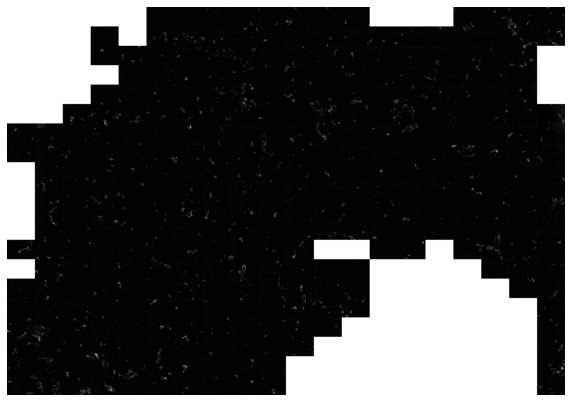

In [68]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img2,vmax=255, cmap='gray')

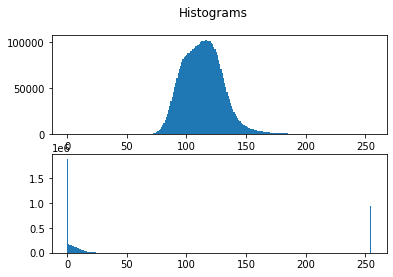

In [70]:
def histograms():
    img_flatten = img.flatten()
    img2_flatten = img2.flatten()
    fig, (ax1, ax2) = plt.subplots(2)
    fig.suptitle('Histograms')
    ax1.hist(img_flatten, bins=256, range=(0,255) )
    ax2.hist(img2_flatten, bins=256, range=(0,255))
histograms()

In [76]:
def segmentation(low,denoise,small):
    img_denoised = denoise_tv_chambolle(img2, weight=denoise)
    img_segm = (img2 > np.median(img_denoised)+low) & (img_denoised <= 255)
    img_segm = morphology.remove_small_objects(img_segm, small)
    return img_segm
img_segm = segmentation(20,6,20)

In [ ]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img_segm,vmax=255, cmap='gray')

In [91]:
def label_img():
    #img_label = label(img_denoised)
    img2_label = label(img_segm)
   # img_label = clear_border(img_label)
    img2_label = clear_border(img2_label)
    #img_label_overlay = label2rgb(img_label, bg_label=0)
    img2_label_overlay = label2rgb(img2_label, bg_label=0)
    props = regionprops(img2_label, extra_properties=())

    props = regionprops_table(img2_label, img,
                           properties=['area',
                                       'convex_area',
                                       'equivalent_diameter', 
                                       'major_axis_length', 
                                       'minor_axis_length',
                                       'bbox', 'perimeter',
                                       'feret_diameter_max', 
                                       'image'
                                       ])
    props = pd.DataFrame(props)
    props['img'] = [img]*len(props)
    for i in range(len(props)):
        props.loc[i,'img'] = [img[int(props['bbox-0'][i]):int(props['bbox-2'][i]), int(props['bbox-1'][i]):int(props['bbox-3'][i])]]
    data_nm = props.copy()
    data_nm = data_nm.drop(columns=['image',
                                    'bbox-0', 
                                    'bbox-1', 
                                    'bbox-2', 
                                    'bbox-3',
                                    'img'])

    data_nm[data_nm.columns[0:2]].apply(lambda x:x*pixelsize)
    data_nm[data_nm.columns[0:6]].apply(lambda x:x*pixelsize)
   # data_nm[data_nm.columns[0:6]]*=pixelsize
   # data_nm[data_nm.columns[0:2]]*=pixelsize
    data_nm['circularity'] =data_nm['area']/data_nm['convex_area']
    #data_nm.to_csv('data_nm.csv')
    return img2_label, img2_label_overlay, data_nm
img2_label, img2_label_overlay, data_nm = label_img()

In [92]:
data_nm

,area,convex_area,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,feret_diameter_max,circularity
0,51,58,8.058239,11.352703,5.898705,27.556349,12.041595,0.879310
1,39,48,7.046726,12.559783,4.967818,29.106602,13.038405,0.812500
2,87,110,10.524820,14.172073,8.762753,39.384776,15.811388,0.790909
3,68,84,9.304853,10.425550,10.021946,46.077164,11.180340,0.809524
4,28,36,5.970821,7.561428,5.518828,20.278175,8.062258,0.777778
...,...,...,...,...,...,...,...,...
605,147,176,13.680870,16.458351,12.337406,56.976659,18.027756,0.835227
606,22,31,5.292567,11.156659,2.901984,19.692388,11.180340,0.709677
607,32,42,6.383076,9.148227,5.742979,25.485281,8.944272,0.761905
608,188,277,15.471556,31.293658,10.460831,98.669048,29.274562,0.678700


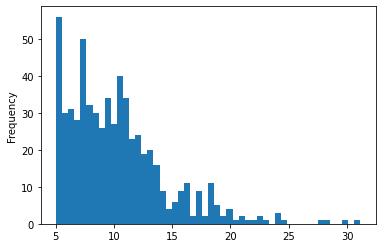

In [93]:
 data_nm['equivalent_diameter'].plot.hist(bins=50)